In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import (nu, fu, osp, DataFrame, np)
from datetime import timedelta
import os

In [8]:

# Get all CSVs into one data frame
frvrs_logs_df = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df')['frvrs_logs_df']
print(frvrs_logs_df.shape) # (829277, 114)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/home/dbabbitt/anaconda3/envs/itm_analysis_reporting/lib/python3.7/site-packages/pandas/_libs/internals.cpython-37m-x86_64-linux-gnu.so'>
No pickle exists for frvrs_logs_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/frvrs_logs_df.csv.
(829116, 113)



## Abstract Final Actions


### Median "triage accuracy" across participants as "correctly tagged patients divided by 11"

I'm assuming the denominator here is 11 taggable patients. If not, then it should be the total amount of patients that can be taggable in the scene. So then the definition is as follows: median "triage accuracy" across participants as "correctly tagged patients divided by the total amount of patients that can be treated in the scene". I think it should be 11 given what Nick has been saying and that's also how they do the post-review report.

The average "triage accuracy" across participants is 72.8%
The median number of correct taggings is 8.0.


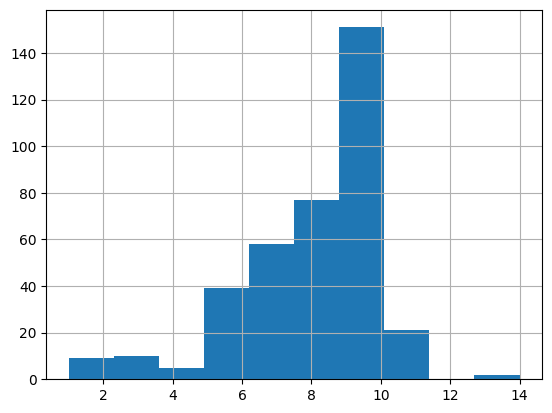

In [5]:

# Filter out the non-aborted triage scenes in each one-per-file file
tag_to_salt_df = nu.load_object('tag_to_salt_df')
base_mask_series = (tag_to_salt_df.scene_type == 'Triage') & (tag_to_salt_df.is_scene_aborted == False)
base_mask_series &= (tag_to_salt_df.is_a_one_triage_file == True)

df = tag_to_salt_df[base_mask_series].groupby(
    fu.scene_groupby_columns + ['is_tag_correct']
).count().patient_id.reset_index(drop=False).rename(columns={'patient_id': 'tagged_count'})
mask_series = (df.is_tag_correct == True)
ave_triage_accuracy = 100 * df[mask_series].tagged_count.mean() / 11

# The average "triage accuracy" across participants is 72.8%
print(f'The average "triage accuracy" across participants is {ave_triage_accuracy:.01f}%')
print(f'The median number of correct taggings is {df[mask_series].tagged_count.median()}.') # The median number of correct taggings is 8.0.
df[mask_series].tagged_count.hist();


1.  **Create new sample with clear count of responders and provide final number of responders here: The total number of responders in this data set was as follows: <u data-renderer-mark="true">362</u>**

    1.  Exclude training session and aborted session CSV files from dataset

    2.  Exclude CSV files with more than one triage run


2.  **Take the newly created data set and compute the following statistics:**


    a.  Calculate triage time defined as “time start of session until time end of session”

        Median = 7:36, SD = ±2:27, IQR = (6:13, 8:59)

In [7]:

# Get the run's entire history
rows_list = []
for (session_uuid, scene_id), scene_df in frvrs_logs_df[base_mask_series].groupby(fu.scene_groupby_columns):
    row_dict = {}
    for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
    time_start = fu.get_scene_start(scene_df)
    row_dict['time_start'] = time_start
    time_stop = fu.get_scene_end(scene_df)
    row_dict['time_stop'] = time_stop
    row_dict['triage_time'] = time_stop - time_start
    rows_list.append(row_dict)
run_time_df = DataFrame(rows_list)
fu.show_time_statistics(run_time_df, ['triage_time'])

,mean,mode,median,SD,min,25%,50%,75%,max
triage_time,7:36,10:22,7:38,±2:27,11 sec,6:13,7:38,8:59,15:52



    b.  Calculate time to hemorrhage control for scene defined as “time of start scene to time last hemorrhage control (last tourniquet applied)”

        Median = 4:54, SD = ±1:48, IQR = (3:57, 6:08)

In [10]:

# Get the total and bleeder scene count
scene_mask_series = base_mask_series & frvrs_logs_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
scene_mask_series &= ~frvrs_logs_df.patient_record_salt.isin(['DEAD', 'EXPECTANT'])

In [11]:

# Iterate through each patient in each run in each file
rows_list = []
for (session_uuid, scene_id), _ in frvrs_logs_df[scene_mask_series].groupby(fu.scene_groupby_columns):
    
    # Get the entire history of this scene for the run start
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
    scene_df = frvrs_logs_df[mask_series]
    time_start = fu.get_scene_start(scene_df)
    
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        patient_mask_series = patient_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
        patient_mask_series &= ~patient_df.patient_record_salt.isin(['DEAD', 'EXPECTANT'])
        if patient_df[patient_mask_series].shape[0]:
            row_dict = {}
            for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
            row_dict['scene_start_time'] = time_start
            mask_series = patient_df.tool_applied_attach_message.isin(['AppliedTourniquet', 'AppliedPackingGauze'])
            control_start = patient_df[mask_series].action_tick.min()
            row_dict['control_start_time'] = control_start
            row_dict['control_delta'] = control_start - time_start
            rows_list.append(row_dict)

run_control_time_df = DataFrame(rows_list)
df = run_control_time_df.groupby(fu.scene_groupby_columns).max()

# 	mean	mode	median	SD	min	25%	50%	75%	max
# control_delta	5 min	5:38	4:54	±1:40	46 sec	3:56	4:54	6:08	12:14
fu.show_time_statistics(df, ['control_delta'])

,mean,mode,median,SD,min,25%,50%,75%,max
control_delta,5 min,5:38,4:54,±1:40,46 sec,3:56,4:54,6:08,12:14



    c.  Calculate hemorrhage control per patient defined as “time patient engaged to time tool applied (tourniquet) for that patient”

        1.  Median = 14 sec, SD = ±28 sec, IQR = 9 sec, 23 sec)

In [12]:

# Iterate through each patient in each run in each file
rows_list = []
for (session_uuid, scene_id, patient_id), _ in frvrs_logs_df[scene_mask_series].groupby(fu.patient_groupby_columns):
    
    # Get the entire history of this patient for the engagement start
    mask_series = True
    for cn in fu.patient_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
    patient_df = frvrs_logs_df[mask_series]

    # Use the first interaction as the "time patient engaged"
    time_start = fu.get_first_patient_interaction(patient_df)
    
    row_dict = {}
    for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
    row_dict['engagement_start_time'] = time_start
    mask_series = patient_df.tool_applied_attach_message.isin(['AppliedTourniquet', 'AppliedPackingGauze'])
    control_start = patient_df[mask_series].action_tick.max()
    row_dict['control_start_time'] = control_start
    row_dict['control_delta'] = control_start - time_start
    rows_list.append(row_dict)

engagement_control_time_df = DataFrame(rows_list)
columns_list = ['control_delta']
df = engagement_control_time_df.groupby(fu.scene_groupby_columns)[columns_list].mean()

# 	mean	mode	median	SD	min	25%	50%	75%	max
# control_delta	23 sec	0 sec	14 sec	±26 sec	0 sec	9 sec	14 sec	22 sec	3:07
fu.show_time_statistics(df, columns_list)

,mean,mode,median,SD,min,25%,50%,75%,max
control_delta,23 sec,0 sec,14 sec,±26 sec,0 sec,9 sec,14 sec,22 sec,3:07



3.  **Calculate the proportion of responders that consistently evaluated patients appropriately in this order: still, able to wave, and able to walk.**

    a.  Responders who evaluated patients in correct order: **<u data-renderer-mark="true">16.15%</u>**

In [ ]:

engagement_sort_df = nu.load_object('engagement_sort_df')

# Get the percentage tag correct counts for each scene for each group
percentage_correct_sort_df = fu.get_percentage_tag_correct_data_frame(engagement_sort_df[base_mask_series], groupby_column='logger_version')

In [6]:

# Loop through each unique file combination
responders_count = sum([fu.get_is_a_one_triage_file(file_name_df) for file_name, file_name_df in frvrs_logs_df.groupby('file_name')])

# Infer the number of responders from the files with one triage scene
print(
    '''OSU has cleaned/revised the files. The most common problem was that we previously only had one "Gary" as our training so many of these had a "Gary" and'''
    ''' then the triage run. (I am keying on "Mike" to exclude the training sessions.) At any rate, it was easier for them to just delete the "Gary" training'''
    ''' session from the files. 

There were a few where OSU could not figure out what was going on, so they just deleted them. It is not worth it to fuss with them since we have plenty of data.'''
    ''' (OSU noted these in the spreadsheet.)''')
print(
    '\nExcluding training and aborted runs from the dataset, the total number of responders in this data set after the'
    f' OSU revision of the double-triaged files is now {responders_count}'
    ' (assuming responders are represented in one and only one file with one training run in it).'
)

OSU has cleaned/revised the files. The most common problem was that we previously only had one "Gary" as our training so many of these had a "Gary" and then the triage run. (I am keying on "Mike" to exclude the training sessions.) At any rate, it was easier for them to just delete the "Gary" training session from the files. 

There were a few where OSU could not figure out what was going on, so they just deleted them. It is not worth it to fuss with them since we have plenty of data. (OSU noted these in the spreadsheet.)

Excluding training and aborted runs from the dataset, the total number of responders in this data set after the OSU revision of the double-triaged files is now 389 (assuming responders are represented in one and only one file with one training run in it).


In [14]:

ave_percentage_correct = percentage_correct_sort_df.percentage_correct.mean()#, 100*df.count_correct.sum()/df.total_count.sum()
print(
    f'Responders who evaluated patients in correct order: {ave_percentage_correct:.2f}%'
    f' (100*{percentage_correct_sort_df.count_correct.sum()}/{percentage_correct_sort_df.total_count.sum()};'
    f' {responders_count-percentage_correct_sort_df.total_count.sum()}'
    f' of the {responders_count} did not have patients with patient_engaged_sort designations).'
    )

Responders who evaluated patients in correct order: 16.15% (100*52/322; 67 of the 389 did not have patients with patient_engaged_sort designations).



## Abstract Edits

In [18]:

mask_series = (frvrs_logs_df.is_a_one_triage_file == True) & (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False)
ave_patients_count = frvrs_logs_df[mask_series].groupby(fu.scene_groupby_columns).patient_id.nunique().mean()

columns_list = ['control_delta']
df = run_control_time_df.groupby(fu.scene_groupby_columns)[columns_list].max()
tttt_dict = nu.get_statistics(df, columns_list).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x))).replace('sec', 'seconds').replace(
    'min', 'minutes'
), na_action='ignore').to_dict()['control_delta']

ave_percentage_correct = percentage_correct_sort_df.percentage_correct.mean()

columns_list = ['triage_time']
tt_dict = nu.get_statistics(run_time_df, columns_list).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x))).replace('sec', 'seconds').replace(
    'min', 'minutes'
), na_action='ignore').to_dict()['triage_time']

columns_list = ['control_delta']
df = engagement_control_time_df.groupby(fu.scene_groupby_columns)[columns_list].mean()

columns_list = ['control_delta']
df = engagement_control_time_df.groupby(fu.scene_groupby_columns)[columns_list].mean()
hcpp_dict = nu.get_statistics(df, columns_list).applymap(lambda x: fu.format_timedelta(timedelta(milliseconds=int(x))).replace('sec', 'seconds').replace(
    'min', 'minutes'
), na_action='ignore').to_dict()['control_delta']

results_str = f"""RESULTS: A total of {responders_count} participants triaged an average of {ave_patients_count:.0f} patients each in the VR First Responder"""
results_str += f""" simulation. Median total time to triage the scene was {tt_dict['median']} (SD = {tt_dict['SD']}, IQR = {tt_dict['25%']}, {tt_dict['75%']})."""
results_str += f""" Through their sorting process, {ave_percentage_correct:.0f}% of clinicians consistently evaluated patients appropriately in this order: still,"""
results_str += f""" able to wave, and able to walk. Median time to life-threatening hemorrhage control was {tttt_dict['median']} (SD = {tttt_dict['SD']},"""
results_str += f""" IQR = {tttt_dict['25%']}, {tttt_dict['75%']}). Median time for hemorrhage control per patient was low at {hcpp_dict['median']}"""
results_str += f""" (SD = {hcpp_dict['SD']}, IQR = {hcpp_dict['25%']}, {hcpp_dict['75%']})."""
print(results_str)

RESULTS: A total of 389 participants triaged an average of 11 patients each in the VR First Responder simulation. Median total time to triage the scene was 7:38 (SD = 2:27, IQR = 6:13, 8:59). Through their sorting process, 16% of clinicians consistently evaluated patients appropriately in this order: still, able to wave, and able to walk. Median time to life-threatening hemorrhage control was 4:54 (SD = 1:48, IQR = 3:57, 6:08). Median time for hemorrhage control per patient was low at 14 seconds (SD = 28 seconds, IQR = 9 seconds, 23 seconds).
